In [1]:
from score_models import ScoreModel
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from torch.func import vmap, grad 
from tqdm import tqdm
import sys
sys.path.append("../models/")
from gridding import ft, ift 
from posterior_sampling import euler_sampler, sigma, real_to_complex, complex_to_real
from forward_model import link_function
plt.style.use("dark_background")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Loading the weights for a score model trained on a prior: 
skirt = "../../score_models/ncsnpp_vp_skirt_y_64_230813225149/"
probes = "../../score_models/ncsnpp_probes_g_64_230604024652/"

prior = probes

if "skirt" in prior: 
    prior_name = "skirt"
    norm = LogNorm(vmin= 1e-2, clip = True)
    B = 1
    C = 0
    def link_function(x): 
        return B * x + C
    print("Setting the Skirt's parameters...")

else: 
    prior_name = "probes"
    norm = None
    B = 1/2
    C = 1/2
    def link_function(x):
        return B * x + C
    print("Setting the Probes' parameters...")

score_model = ScoreModel(checkpoints_directory = prior)

Setting the Probes' parameters...
Using the Variance Exploding SDE


In [3]:
data_path = "../../../data/"
prior_samples = torch.load(data_path + prior_name + "_prior_samples.pt")
sampling_function = torch.tensor(np.load(data_path + "\data_htlup\sampling_function3.npy"))[:256**2]

S = sampling_function.reshape(256, 256).to(device)

sample = prior_samples[0, 0]
padded_sample = torch.nn.functional.pad(prior_samples[0,0], [96, 96, 96, 96])

In [4]:
def dirty_imager(x, sampling_function): 
    dirty_image = ift(ft(x) * sampling_function.to(torch.uint8))
    return dirty_image.real

def padding(x, pad): 
    H, W = x.shape
    return torch.nn.functional.pad(x, [pad, pad, pad, pad])

def unpadding(x, pad):
    H, W = x.shape
    full_img = x.shape[-1]
    img_size = full_img - 2* pad
    T = (full_img+ img_size)//2 
    D = (full_img-img_size)//2 
    L = (full_img-img_size)//2 
    R = (full_img+ img_size)//2  
    return x[D:T,L:R].reshape(img_size, img_size)


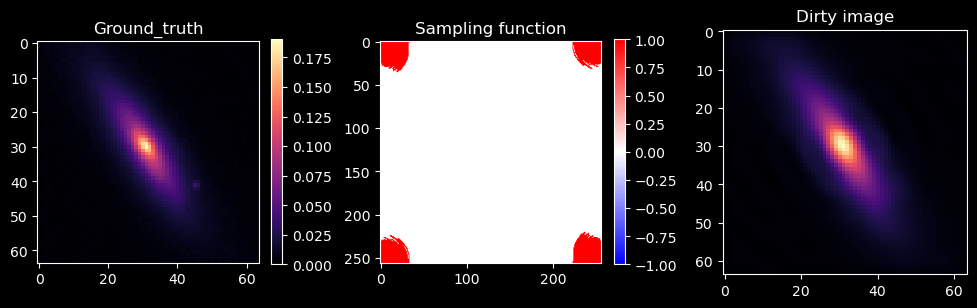

In [5]:
fig, axs = plt.subplots(1, 3, figsize = (3*4, 4))
    
padded_sample = padding(link_function(prior_samples[0,0]), pad = 96)
im = axs[0].imshow(unpadding(padded_sample, pad = 96).cpu().numpy(), norm = norm, cmap = "magma")
axs[0].set_title("Ground_truth")
plt.colorbar(im, ax = axs[0], fraction = 0.046)

im = axs[1].imshow(S.squeeze().cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[1], fraction = 0.046)
axs[1].set_title("Sampling function")

dirty_image = dirty_imager(padded_sample, S)
dirty_image = unpadding(dirty_image, pad = 96)
axs[2].imshow(dirty_image.squeeze().cpu().numpy(), norm = norm, cmap = "magma")
axs[2].set_title("Dirty image")

plt.subplots_adjust(wspace=0.4)

In [6]:
from forward_model import model, model_to_plot

In [7]:
t = torch.zeros(size = (1,1)).to(device)

model_parameters = (S, B, C, 96)
x = prior_samples[0]

# Creating an observation
sigma_y = 1e-4
y = model(t, x, score_model = score_model, model_parameters = model_parameters)
y += sigma_y * torch.randn_like(y)

Text(0.5, 1.0, 'Sampling function')

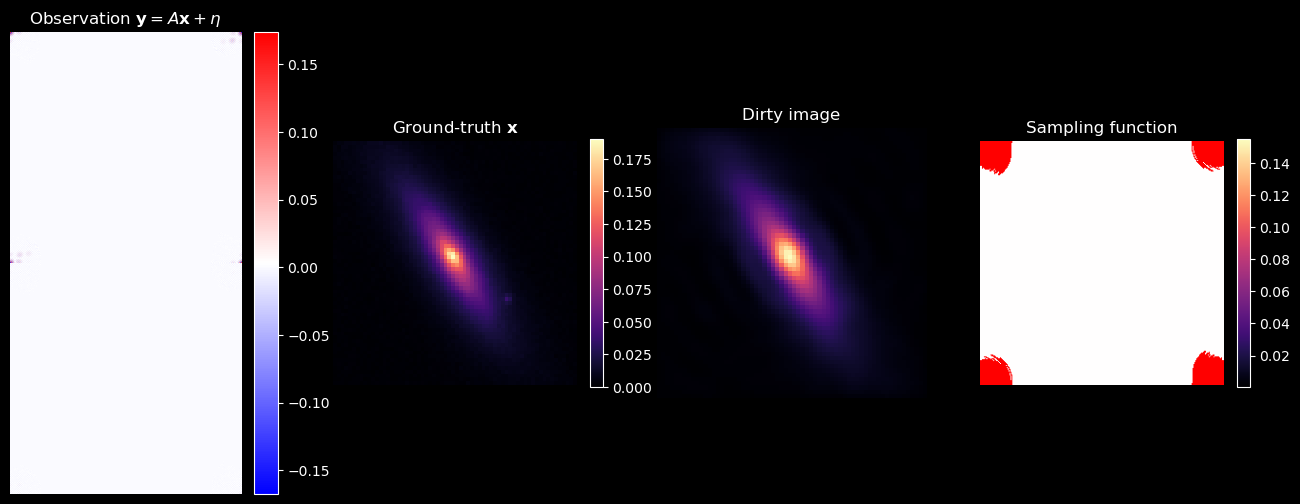

In [8]:
y_to_plot = model_to_plot(t, x, score_model = score_model, model_parameters = model_parameters)
dirty_image = unpadding(ift(real_to_complex(y_to_plot.squeeze())).real, pad = 96)

# Verifying I don't do weird stuff
n_cols = 4
fig, axs = plt.subplots(1, n_cols, figsize = (n_cols * 4, 6))

for i in range(n_cols): 
    axs[i].axis("off")

im = axs[0].imshow(y_to_plot.reshape(-1,256).cpu(), cmap = "bwr")
axs[0].set_title(r"Observation $\mathbf{y} = A\mathbf{x} +\eta$")
plt.colorbar(im, fraction = 2 * 0.046)
im = axs[1].imshow(link_function(x).squeeze().cpu(), norm = norm, cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

im = axs[2].imshow(dirty_image.squeeze().cpu(), norm = norm, cmap = "magma")
axs[2].set_title("Dirty image")

m = axs[3].imshow(S.squeeze().cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[3], fraction = 0.046)
axs[3].set_title("Sampling function")

In [9]:
from forward_model import score_likelihood, log_likelihood
from posterior_sampling import euler_sampler, old_pc_sampler

In [10]:
# Sanity check
t = torch.ones(size = (1, 1)).to(device)
x = torch.randn(size = (1, 64, 64)).to(device)
log_likelihood(t, x, y, sigma_y, forward_model=model, score_model = score_model, model_parameters = model_parameters)

tensor(-484.9683, device='cuda:0')

In [11]:
from posterior_sampling import mu, sigma, g, drift_fn
def score_posterior(t, x, y, sigma_y, forward_model, score_model, score_likelihood, model_parameters, tweedie):
    if tweedie: 
        sigma_t = sigma(t, score_model)[0].item() # During sampling every sample is evaluated at the same temperature so there's no issue with this
        mu_t = mu(t, score_model)[0].item()
        #tweedie_x = (x + sigma(t, score_model)**2 * score_model.score(t, x))/ mu(t, score_model)
        tweedie_x = (x + sigma_t ** 2 * score_model.score(t, x)) / mu_t
    else: 
        tweedie_x = x
    score_prior = score_model.score(t, x)
    score_lh = score_likelihood(t, tweedie_x, y, sigma_y, forward_model=forward_model, score_model=score_model, model_parameters = model_parameters)
    return score_prior + score_lh

def old_pc_sampler(y, sigma_y, forward_model, score_model, score_likelihood, model_parameters, num_samples, pc_params, tweedie = False, keep_chain = False, test_time = False, img_size = (64, 64)): 
    pred_steps, corr_steps, snr = pc_params
    
    t = torch.ones(size = (num_samples,1)).to(device)
    sigma_max = sigma(t, score_model)[0]
    x = sigma_max * torch.randn([num_samples, 1, *img_size]).to(device)
    dt = -1/pred_steps 

    chain = []
    with torch.no_grad(): 
        for i in tqdm(range(pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient =  score_posterior(t, x, y, sigma_y, forward_model, score_model, score_likelihood, model_parameters, tweedie = tweedie)
            for _ in range(corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient =  score_posterior(t, x, y, sigma_y, forward_model, score_model, score_likelihood, model_parameters, tweedie = tweedie)
            drift = drift_fn(t, x, score_model)
            diffusion = g(t, x, score_model)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            # To avoid numerical instabilities due to vanishing variances
            if t<1e-6:
                break

            if torch.isnan(x).any().item(): 
                print("Nans appearing, stopping sampling...")
                break

            if test_time and i==20:
                break

            if keep_chain: 
                chain.append(x.cpu().numpy())

            if test_time and i==20: 
                    break

        if keep_chain: 
            return x_mean, chain 
        else: 
            return x_mean  

In [12]:
1-500*1/500

0.0

In [13]:
str(score_model.sde)

'<score_models.sde.vesde.VESDE object at 0x000001E519AE0430>'

In [15]:
# samples = euler_sampler(
#     y = y,
#     sigma_y = sigma_y,
#     forward_model = model, 
#     score_model = score_model, 
#     score_likelihood = score_likelihood, 
#     model_parameters = model_parameters,
#     num_samples = 4, 
#     num_steps = 500, 
#     tweedie = False, 
#     keep_chain = False, 
#     test_time = False, 
#     img_size = (64, 64)
# )
num_samples = 4
pred_steps = 500
corr_steps = 2
snr = 0.1
samples = old_pc_sampler(
    y = y,
    sigma_y = sigma_y, 
    forward_model = model, 
    score_model = score_model, 
    score_likelihood = score_likelihood, 
    model_parameters = model_parameters,
    num_samples = 4,
    pc_params = (pred_steps, corr_steps, snr),
    img_size = (64, 64), 
    keep_chain = False, 
    test_time= False
)

  0%|          | 0/499 [00:00<?, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

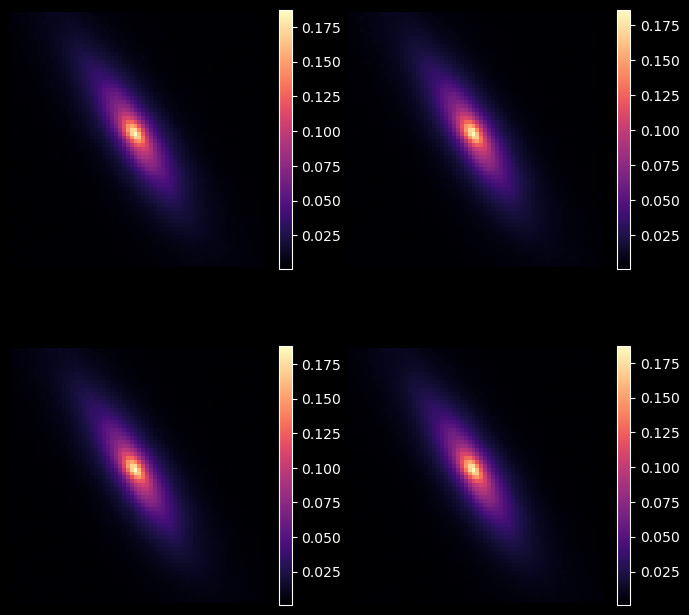

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (4*2, 4*2))


k = 0
for i in range(2): 
    for j in range(2):
        im = axs[i, j].imshow(link_function(samples[k]).squeeze().cpu(), norm = norm, cmap = "magma")
        plt.colorbar(im, fraction = 0.046)
        axs[i,j].axis("off")
        k+=1
